In [1]:
# Initialize settings

# ============================================================
# Define paths for 
#     processed_path: where processed data lives 
#     output_path: where to store output
#     program_path: where the code lives (organoid analysis)
# ============================================================

ina_path = {
    'processed_path': '/awlab/projects/2015_08_gut_organoid_analysis/data/processed_data',
    'output_path': '/awlab/projects/2015_08_gut_organoid_analysis/analysis_output',
    'program_path': '/awlab/projects/2015_08_gut_organoid_analysis/organoid_analysis/organoid_analysis'
}

lani_path = {
    'processed_path': 'W:\\2015_08_gut_organoid_analysis/data/processed_data',
    'output_path': 'W:\\2015_08_gut_organoid_analysis/analysis_output',
    'program_path': 'W:\\2015_08_gut_organoid_analysis\organoid_analysis\organoid_analysis'
}

path_init = ina_path

# should plots be saved?
save_plot = True

# folder to save output
subdir = 'code_review'

In [2]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.colors as mcolors

from collections import OrderedDict
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from scipy import stats
import seaborn as sns

In [3]:
# Repository Setup

# goto program folder
os.chdir(path_init['program_path'])

# import helper packages
from utils import constants, config

In [4]:
# Paths

# filenames
fname_lookup={
    'cell': 'num_cells_well_measure.csv',
    'cellstain': 'num_cellstain_well_measure.csv',
    'double': 'num_double_well_measure.csv',
    'edu': 'num_edu_well_measure.csv',
    'paneth': 'num_paneth_well_measure.csv',
    'single_edu': 'num_single_edu_well_measure.csv',
    'single_ki67': 'num_single_ki67_well_measure.csv',
    'crypt_cell': 'num_crypt_cells_well_measure.csv',
    'crypt_cellstain': 'num_crypt_cellstain_well_measure.csv',
    'crypt_double': 'num_crypt_double_well_measure.csv',
    'crypt_edu': 'num_crypt_edu_well_measure.csv',
    'crypt_paneth': 'num_crypt_paneth_well_measure.csv',
    'crypt': 'num_crypts_well_measure.csv',
    'eccentricity': 'avg_eccentricity_well_measure.csv',
    'solidity': 'avg_solidity_well_measure.csv',
    'paneth_drop': 'num_paneth_drop_well_measure.csv',
    'villus_cell': 'num_villus_cells_well_measure.csv',
    'villus_cellstain': 'num_villus_cellstain_well_measure.csv',
    'villus_double': 'num_villus_double_well_measure.csv',
    'villus_edu': 'num_villus_edu_well_measure.csv',
    'villus_paneth': 'num_villus_paneth_well_measure.csv'
}

# output path
output_path = path_init['output_path']

# data file path template
data_path = os.path.join(path_init['processed_path'], '{{exp:s}}/{run_type:s}/combined/well_measure/{fname:s}')

outdir_path = os.path.join(output_path, '{subdir:s}')
outsvg_path = os.path.join(outdir_path, '{fname:s}.svg')
outpng_path = os.path.join(outdir_path, '{fname:s}.png')
outcsv_path = os.path.join(outdir_path, '{fname:s}.csv')

In [5]:
# Constants

# plot labels
xlabs = constants.get_96_cols()
ylabs = constants.get_96_rows()

# plot colors
c = mcolors.ColorConverter().to_rgb

if save_plot:
    mpl.rcParams['text.color'] = 'k'
    mpl.rcParams['axes.labelcolor'] = 'k'
    mpl.rcParams['xtick.color'] = 'k'
    mpl.rcParams['ytick.color'] = 'k'
else:
    mpl.rcParams['text.color'] = 'w'
    mpl.rcParams['axes.labelcolor'] = 'w'
    mpl.rcParams['xtick.color'] = 'w'
    mpl.rcParams['ytick.color'] = 'w'
    
# plot styles
line_palette = ['#000000', '#339933', '#339933', '#cc0000', '#cc0000']
line_style = ['-', '-', '--', '-', '--']
line_palette_celltype = ['#f8766d', '#00b935', '#619cff'] #http://www.cookbook-r.com/Graphs/Colors_(ggplot2)
fig2_line_palette = ['#000000', '#ff9999', '#002080']
bar_palette = 'black'
heatmap_monocolor = plt.cm.Reds_r #'YlOrRd_r' seismic

# cropped matrix indices
wntbmp_rows = [0,2,3,4,5,6,7]
wntbmp_cols = [2, 3, 4, 5, 6, 7, 8, 9, 10]
paneth_rows = [0,2,3,4,5,6]
paneth_cols = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# figure settings
fig_sz = (10, 7)

# dual heatmap params
center_x = 0
center_y = -1

In [6]:
# Dataframe helper functions

def val_from_matrix(datapoint, matrix_path):
    """Looks up data value given datapoint info
    
    Args: 
        datapoint (dict): contains at minimum exp name, row, col 
            e.g. dict(exp='expname', row='A', col=1)
        matrix_path (str): path to data file (with exp unformatted)
            e.g. '/path/to/data/file/{exp}'
        
    Returns:
        float: data value 
    """
    
    # generate data path
    fpath = matrix_path.format(exp=datapoint['exp'])
    row = constants.get_96_rows().index(datapoint['row'])
    col = constants.get_96_cols().index(datapoint['col'])

    dat = pd.read_csv(fpath, header=None).as_matrix()
    return dat[row][col]

def df_from_datatray(datatray, path_template, label=None):
    """Generates dataframe from datatray (list of data points) and path template for data files
    
    Args: 
        datatray (list): data points (dictionaries)
        path_template (str): path to data files 
        label (str): add 'label' value to all entries 
        
    Returns:
        dataframe: pd dataframe of all data points
    """
    
    df = pd.DataFrame()
    for d in datatray:
        # look up data value
        d['val'] = val_from_matrix(d, path_template)
        if label:
            d['label'] = label
        df = df.append(d, ignore_index=True)
    return df

def df_ratio_from_matrix(datatray, top_path, bottom_path, label=None):
    """Generates dataframe from datatray (list of data points) and two path templates for data files. 
    The ratio is calculated as the data value
    
    Args: 
        datatray (list): data points (dictionaries)
        top_path, bottom_path (str): path to data files. ratio = top/bottom
        label (str): add 'label' value to all entries 
        
    Returns:
        dataframe: pd dataframe of all data points
    """
    
    df = pd.DataFrame()
    for d in datatray:
        # look up data value
        top_val = val_from_matrix(d, top_path)
        bottom_val = val_from_matrix(d, bottom_path)
        d['val'] = top_val/bottom_val
        if label:
            d['label'] = label
        df = df.append(d, ignore_index=True)
    return df

def df_ratio_from_datatray(datatray, top_path, bottom_path, label=None):
    """Generates dataframe from datatray (list of data points) and two path templates for data files. 
    The ratio is calculated as the data value
    
    Args: 
        datatray (list): data points (dictionaries)
        top_path, bottom_path (str): path to data files. ratio = top/bottom
        label (str): add 'label' value to all entries 
        
    Returns:
        dataframe: pd dataframe of all data points
    """
    
    df = pd.DataFrame()
    for d in datatray:
        # look up data value
        top_val = val_from_matrix(d, top_path)
        bottom_val = val_from_matrix(d, bottom_path)
        d['val'] = top_val/bottom_val
        if label:
            d['label'] = label
        df = df.append(d, ignore_index=True)
    return df

In [7]:
# Figure helper functions

def make_colormap(seq):
    """Generate a LinearSegmentedColormap
    
    Args:
        seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval [0,1]
    
    Returns:
        LinearSegmentedColormap: from mcolors
    """
    
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    
    # make color sequence
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

def red_blue_colormap(levels):
    """Generate dual color gradient from blue to white to red"""
    
    x1, x2, x3, x4 = levels
    palette = make_colormap([c('blue'), x1, c('blue'), c('white'), x2, c('white'), x3, c('white'), c('red'), x4, c('red')])
    palette.set_bad('#2e2e2e', 1.0)
    return palette

def red_colormap(levels):
    """Generate single color gradient from red to white"""
    
    x1, x2 = levels
    palette = make_colormap([c('red'), x1, c('red'), c('white'), x2, c('white')])
    palette.set_bad('#2e2e2e', 1.0)
    return palette

def get_levels(center1, center2, max_val, min_val, fold=None):
    """Get levels for dual color maps 
    
    Args:
        center1, center2 (float): center interval upper and lower val
        max_val, min_val (float): max and min value of colormap
        
    Returns:
        list: list of 4 floats in increasing order in interval [0,1]
    """
    
    # calculate range
    avg = np.mean([center1, center2])
    diff = abs(center1-center2)
    total = 2*max(abs(max_val - avg), abs(min_val - avg))
    
    # calculate levels
    center_bot = 0.5 - diff/(2*total)
    center_top = 0.5 + diff/(2*total)
    
    if fold is None:
        fold_bot = 0.33*avg / total
        fold_top = 1.5*avg / total
    else:
        mid = total /2 
        fold_bot = max(0, 0.5 - (1-(1.0/fold))*mid / total)
        fold_top = min(1, (fold-1)*mid / total + 0.5)
    
    return [fold_bot, center_bot, center_top, fold_top]

def get_vmax(center1, center2, max_val, min_val):
    """Calculate vmax as at least 1.5 times of average"""
    avg = np.mean([center1, center2])
    vmax = avg + max(abs(max_val - avg), abs(min_val - avg))
    
    if vmax < (1.5*avg):
        vmax = 1.5*avg
    
    return vmax

def get_vmax_fold(center1, center2, fold):
    """Calculate vmax as at least fold times of average"""
    avg = np.mean([center1, center2])
    return fold * avg

def get_center(center1, center2):
    """Calculate center of heatmap colorbar"""
    return np.mean([center1, center2])

def save_csv_fig(subdir=None, fname=None, fig=None, ax=None, df=None, mat=None):
    """Saves figures and csv to file
    
    Args:
        subdir: subdirectory under output path to save
        fname: name of all files 
        fig, ax: figure handle to save 
        df: data frame to save to csv
    
    Returns:
        None
    """
    # check args
    if subdir is None or fname is None:
        raise ValueError('Provide subdir and fname')
        
    if not ((fig is None) ^ (ax is None)):
        raise ValueError('Provide either fig or ax')
        
    # create directory
    dirpath = outdir_path.format(subdir=subdir)
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

    # plot background should be white
    bcolor = '#ffffff'
    
    # save images
    if fig:
        fig.savefig(outpng_path.format(subdir=subdir, fname=fname), facecolor=bcolor, bbox_inches='tight')
        fig.savefig(outsvg_path.format(subdir=subdir, fname=fname), facecolor=bcolor, bbox_inches='tight')
    else:
        ax.savefig(outpng_path.format(subdir=subdir, fname=fname), facecolor=bcolor, bbox_inches='tight')
        ax.savefig(outsvg_path.format(subdir=subdir, fname=fname), facecolor=bcolor, bbox_inches='tight')
        
    # save csv
    if df is not None:
        df.to_csv(outcsv_path.format(subdir=subdir, fname=fname))
    
    if mat is not None:
        np.savetxt(outcsv_path.format(subdir=subdir, fname=fname), mat, delimiter=',')

# def save_csv_fig(subdir=None, fname=None, fig=None, ax=None, df=None):
#     """Saves figures and csv to file
    
#     Args:
#         subdir: subdirectory under output path to save
#         fname: name of all files 
#         fig, ax: figure handle to save 
#         df: data frame to save to csv
    
#     Returns:
#         None
#     """
#     # check args
#     if subdir is None or fname is None:
#         raise ValueError('Provide subdir and fname')
        
#     if not ((fig is None) ^ (ax is None)):
#         raise ValueError('Provide either fig or ax')
        
#     # create directory
#     dirpath = outdir_path.format(subdir=subdir)
#     if not os.path.exists(dirpath):
#         os.makedirs(dirpath)

#     # plot background should be white
#     bcolor = '#ffffff'
    
#     # save images
#     if fig:
#         fig.savefig(outpng_path.format(subdir=subdir, fname=fname), facecolor=bcolor, bbox_inches='tight')
#         fig.savefig(outsvg_path.format(subdir=subdir, fname=fname), facecolor=bcolor, bbox_inches='tight')
#     else:
#         ax.savefig(outpng_path.format(subdir=subdir, fname=fname), facecolor=bcolor, bbox_inches='tight')
#         ax.savefig(outsvg_path.format(subdir=subdir, fname=fname), facecolor=bcolor, bbox_inches='tight')
        
#     # save csv
#     if df is not None:
#         df.to_csv(outcsv_path.format(subdir=subdir, fname=fname))

In [8]:
# Set up paper plots datatrays

# ============================================================
# Datatrays list every data point in a plot
#     exp, row, col: identify plate and well
#     name: group name for data point
#     time: time point
# ============================================================

fig2_line_datatray = [
    dict(exp='ct25_0', row='B', col=3, name='0'),
    dict(exp='ct25_0', row='B', col=4, name='0'),
    dict(exp='ct25_0', row='C', col=3, name='0'),
    dict(exp='ct25_0', row='C', col=4, name='0'),

    dict(exp='ct25_24', row='A', col=1, name='24'),
    dict(exp='ct25_24', row='A', col=2, name='24'),
    dict(exp='ct25_24', row='B', col=1, name='24'),
    dict(exp='ct25_24', row='B', col=2, name='24'),

    dict(exp='ct25_48', row='A', col=1, name='48'),
    dict(exp='ct25_48', row='A', col=2, name='48'),
    dict(exp='ct25_48', row='B', col=1, name='48'),
    dict(exp='ct25_48', row='B', col=2, name='48'),

    dict(exp='ct25_72', row='A', col=1, name='72'),
    dict(exp='ct25_72', row='A', col=2, name='72'),
    dict(exp='ct25_72', row='B', col=1, name='72'),
    dict(exp='ct25_72', row='B', col=2, name='72')
    ]

fig4_line_datatray = [
    dict(exp='ct25_0', row='B', col=3, time='0', name='Control'),
    dict(exp='ct25_0', row='B', col=4, time='0', name='Control'),
    dict(exp='ct25_0', row='C', col=3, time='0', name='Control'),
    dict(exp='ct25_0', row='C', col=4, time='0', name='Control'),

    dict(exp='ct25_24', row='A', col=1, time='24', name='Control'),
    dict(exp='ct25_24', row='A', col=2, time='24', name='Control'),
    dict(exp='ct25_24', row='B', col=1, time='24', name='Control'),
    dict(exp='ct25_24', row='B', col=2, time='24', name='Control'),

    dict(exp='ct25_48', row='A', col=1, time='48', name='Control'),
    dict(exp='ct25_48', row='A', col=2, time='48', name='Control'),
    dict(exp='ct25_48', row='B', col=1, time='48', name='Control'),
    dict(exp='ct25_48', row='B', col=2, time='48', name='Control'),

    dict(exp='ct25_72', row='A', col=1, time='72', name='Control'),
    dict(exp='ct25_72', row='A', col=2, time='72', name='Control'),
    dict(exp='ct25_72', row='B', col=1, time='72', name='Control'),
    dict(exp='ct25_72', row='B', col=2, time='72', name='Control'),
    
    dict(exp='ct25_0', row='D', col=3, time='0', name='WNT3a'),
    dict(exp='ct25_0', row='D', col=4, time='0', name='WNT3a'),
    dict(exp='ct25_0', row='E', col=3, time='0', name='WNT3a'),
    dict(exp='ct25_0', row='E', col=4, time='0', name='WNT3a'),

    dict(exp='ct25_24', row='A', col=5, time='24', name='WNT3a'),
    dict(exp='ct25_24', row='B', col=5, time='24', name='WNT3a'),

    dict(exp='ct25_48', row='A', col=5, time='48', name='WNT3a'),
    dict(exp='ct25_48', row='B', col=5, time='48', name='WNT3a'),

    dict(exp='ct25_72', row='A', col=5, time='72', name='WNT3a'),
    dict(exp='ct25_72', row='B', col=5, time='72', name='WNT3a'),
    
    dict(exp='ct25_0', row='F', col=3, time='0', name='IWP-2'),
    dict(exp='ct25_0', row='F', col=4, time='0', name='IWP-2'),
    dict(exp='ct25_0', row='G', col=3, time='0', name='IWP-2'),
    dict(exp='ct25_0', row='G', col=4, time='0', name='IWP-2'),

    dict(exp='ct25_24', row='C', col=1, time='24', name='IWP-2'),
    dict(exp='ct25_24', row='C', col=2, time='24', name='IWP-2'),
    dict(exp='ct25_24', row='D', col=1, time='24', name='IWP-2'),
    dict(exp='ct25_24', row='D', col=2, time='24', name='IWP-2'),

    dict(exp='ct25_48', row='C', col=1, time='48', name='IWP-2'),
    dict(exp='ct25_48', row='C', col=2, time='48', name='IWP-2'),
    dict(exp='ct25_48', row='D', col=1, time='48', name='IWP-2'),
    dict(exp='ct25_48', row='D', col=2, time='48', name='IWP-2'),

    dict(exp='ct25_72', row='C', col=1, time='72', name='IWP-2'),
    dict(exp='ct25_72', row='C', col=2, time='72', name='IWP-2'),
    dict(exp='ct25_72', row='D', col=1, time='72', name='IWP-2'),
    dict(exp='ct25_72', row='D', col=2, time='72', name='IWP-2'),
    
    dict(exp='ct25_0', row='B', col=5, time='0', name='BMP4'),
    dict(exp='ct25_0', row='B', col=6, time='0', name='BMP4'),
    dict(exp='ct25_0', row='C', col=5, time='0', name='BMP4'),
    dict(exp='ct25_0', row='C', col=6, time='0', name='BMP4'),

    dict(exp='ct25_24', row='E', col=1, time='24', name='BMP4'),
    dict(exp='ct25_24', row='E', col=2, time='24', name='BMP4'),
    dict(exp='ct25_24', row='F', col=1, time='24', name='BMP4'),
    dict(exp='ct25_24', row='F', col=2, time='24', name='BMP4'),

    dict(exp='ct25_48', row='E', col=1, time='48', name='BMP4'),
    dict(exp='ct25_48', row='E', col=2, time='48', name='BMP4'),
    dict(exp='ct25_48', row='F', col=1, time='48', name='BMP4'),
    dict(exp='ct25_48', row='F', col=2, time='48', name='BMP4'),

    dict(exp='ct25_72', row='E', col=1, time='72', name='BMP4'),
    dict(exp='ct25_72', row='E', col=2, time='72', name='BMP4'),
    dict(exp='ct25_72', row='F', col=1, time='72', name='BMP4'),
    dict(exp='ct25_72', row='F', col=2, time='72', name='BMP4'),
    
    dict(exp='ct25_0', row='D', col=5, time='0', name='LDN'),
    dict(exp='ct25_0', row='D', col=6, time='0', name='LDN'),
    dict(exp='ct25_0', row='E', col=6, time='0', name='LDN'),
    dict(exp='ct25_0', row='F', col=6, time='0', name='LDN'),

    dict(exp='ct25_24', row='G', col=1, time='24', name='LDN'),
    dict(exp='ct25_24', row='G', col=2, time='24', name='LDN'),
    dict(exp='ct25_24', row='H', col=1, time='24', name='LDN'),
    dict(exp='ct25_24', row='H', col=2, time='24', name='LDN'),

    dict(exp='ct25_48', row='G', col=1, time='48', name='LDN'),
    dict(exp='ct25_48', row='G', col=2, time='48', name='LDN'),
    dict(exp='ct25_48', row='H', col=1, time='48', name='LDN'),
    dict(exp='ct25_48', row='H', col=2, time='48', name='LDN'),

    dict(exp='ct25_72', row='G', col=1, time='72', name='LDN'),
    dict(exp='ct25_72', row='G', col=2, time='72', name='LDN'),
    dict(exp='ct25_72', row='H', col=1, time='72', name='LDN'),
    dict(exp='ct25_72', row='H', col=2, time='72', name='LDN')
    ]

fig4_bar_72h_datatray = [
    dict(exp='ct25_72', row='A', col=1, time='72', name='Control'),
    dict(exp='ct25_72', row='A', col=2, time='72', name='Control'),
    dict(exp='ct25_72', row='B', col=1, time='72', name='Control'),
    dict(exp='ct25_72', row='B', col=2, time='72', name='Control'),
 
    dict(exp='ct25_72', row='A', col=5, time='72', name='WNT3a'),
    dict(exp='ct25_72', row='B', col=5, time='72', name='WNT3a'),
    
    dict(exp='ct25_72', row='G', col=1, time='72', name='LDN'),
    dict(exp='ct25_72', row='G', col=2, time='72', name='LDN'),
    dict(exp='ct25_72', row='H', col=1, time='72', name='LDN'),
    dict(exp='ct25_72', row='H', col=2, time='72', name='LDN'),
    
    dict(exp='ct25_72', row='G', col=5, time='72', name='LDN + WNT3a'),
    dict(exp='ct25_72', row='H', col=5, time='72', name='LDN + WNT3a')
    ]

fig4_bar_48h_datatray = [
    dict(exp='ct25_48', row='A', col=1, time='48', name='Control'),
    dict(exp='ct25_48', row='A', col=2, time='48', name='Control'),
    dict(exp='ct25_48', row='B', col=1, time='48', name='Control'),
    dict(exp='ct25_48', row='B', col=2, time='48', name='Control'),

    dict(exp='ct25_48', row='C', col=1, time='48', name='IWP-2'),
    dict(exp='ct25_48', row='C', col=2, time='48', name='IWP-2'),
    dict(exp='ct25_48', row='D', col=1, time='48', name='IWP-2'),
    dict(exp='ct25_48', row='D', col=2, time='48', name='IWP-2'),
    
    dict(exp='ct25_48', row='C', col=5, time='48', name='IWP-2 + WNT3a'),
    dict(exp='ct25_48', row='D', col=5, time='48', name='IWP-2 + WNT3a'),
    
    dict(exp='ct25_48', row='A', col=5, time='48', name='WNT3a'),
    dict(exp='ct25_48', row='B', col=5, time='48', name='WNT3a')
    ]

wholetimeseries_datatray = [
    
    dict(exp='ct25_0', row='B', col=3, time='0', name='Control'),
    dict(exp='ct25_0', row='B', col=4, time='0', name='Control'),
    dict(exp='ct25_0', row='C', col=3, time='0', name='Control'),
    dict(exp='ct25_0', row='C', col=4, time='0', name='Control'),
 
    dict(exp='ct25_0', row='D', col=3, time='0', name='WNT3a'),
    dict(exp='ct25_0', row='D', col=4, time='0', name='WNT3a'),
    dict(exp='ct25_0', row='E', col=3, time='0', name='WNT3a'),
    dict(exp='ct25_0', row='E', col=4, time='0', name='WNT3a'),

    dict(exp='ct25_0', row='F', col=3, time='0', name='IWP-2'),
    dict(exp='ct25_0', row='F', col=4, time='0', name='IWP-2'),
    dict(exp='ct25_0', row='G', col=3, time='0', name='IWP-2'),
    dict(exp='ct25_0', row='G', col=4, time='0', name='IWP-2'),
    
    dict(exp='ct25_0', row='B', col=5, time='0', name='IWP-2 + WNT3a'),
    dict(exp='ct25_0', row='B', col=6, time='0', name='IWP-2 + WNT3a'),
    
    dict(exp='ct25_0', row='C', col=5, time='0', name='BMP4 + WNT3a'),
    dict(exp='ct25_0', row='C', col=6, time='0', name='BMP4 + WNT3a'),

    dict(exp='ct25_0', row='D', col=5, time='0', name='LDN'),
    dict(exp='ct25_0', row='D', col=6, time='0', name='LDN'),
    dict(exp='ct25_0', row='E', col=6, time='0', name='LDN'),
    dict(exp='ct25_0', row='F', col=6, time='0', name='LDN'),
    
    dict(exp='ct25_0', row='G', col=6, time='0', name='LDN + WNT3a'),
    dict(exp='ct25_0', row='G', col=6, time='0', name='LDN + WNT3a'),
    
    dict(exp='ct25_24', row='A', col=1, time='24', name='Control'),
    dict(exp='ct25_24', row='A', col=2, time='24', name='Control'),
    dict(exp='ct25_24', row='B', col=1, time='24', name='Control'),
    dict(exp='ct25_24', row='B', col=2, time='24', name='Control'),
 
    dict(exp='ct25_24', row='A', col=5, time='24', name='WNT3a'),
    dict(exp='ct25_24', row='B', col=5, time='24', name='WNT3a'),

    dict(exp='ct25_24', row='C', col=1, time='24', name='IWP-2'),
    dict(exp='ct25_24', row='C', col=2, time='24', name='IWP-2'),
    dict(exp='ct25_24', row='D', col=1, time='24', name='IWP-2'),
    dict(exp='ct25_24', row='D', col=2, time='24', name='IWP-2'),
    
    dict(exp='ct25_24', row='C', col=5, time='24', name='IWP-2 + WNT3a'),
    dict(exp='ct25_24', row='D', col=5, time='24', name='IWP-2 + WNT3a'),
    
    dict(exp='ct25_24', row='E', col=5, time='24', name='BMP4 + WNT3a'),
    dict(exp='ct25_24', row='F', col=5, time='24', name='BMP4 + WNT3a'),

    dict(exp='ct25_24', row='G', col=1, time='24', name='LDN'),
    dict(exp='ct25_24', row='G', col=2, time='24', name='LDN'),
    dict(exp='ct25_24', row='H', col=1, time='24', name='LDN'),
    dict(exp='ct25_24', row='H', col=2, time='24', name='LDN'),
    
    dict(exp='ct25_24', row='G', col=5, time='24', name='LDN + WNT3a'),
    dict(exp='ct25_24', row='H', col=5, time='24', name='LDN + WNT3a'),
    
    dict(exp='ct25_48', row='A', col=1, time='48', name='Control'),
    dict(exp='ct25_48', row='A', col=2, time='48', name='Control'),
    dict(exp='ct25_48', row='B', col=1, time='48', name='Control'),
    dict(exp='ct25_48', row='B', col=2, time='48', name='Control'),
    
    dict(exp='ct25_48', row='A', col=3, time='48', name='loWNT3a'),
    dict(exp='ct25_48', row='A', col=4, time='48', name='loWNT3a'),
    dict(exp='ct25_48', row='B', col=3, time='48', name='loWNT3a'),
    dict(exp='ct25_48', row='B', col=4, time='48', name='loWNT3a'),
    
    dict(exp='ct25_48', row='A', col=5, time='48', name='WNT3a'),
    dict(exp='ct25_48', row='B', col=5, time='48', name='WNT3a'),

    dict(exp='ct25_48', row='C', col=1, time='48', name='IWP-2'),
    dict(exp='ct25_48', row='C', col=2, time='48', name='IWP-2'),
    dict(exp='ct25_48', row='D', col=1, time='48', name='IWP-2'),
    dict(exp='ct25_48', row='D', col=2, time='48', name='IWP-2'),
    
    dict(exp='ct25_48', row='C', col=5, time='48', name='IWP-2 + WNT3a'),
    dict(exp='ct25_48', row='D', col=5, time='48', name='IWP-2 + WNT3a'),

    dict(exp='ct25_48', row='E', col=5, time='48', name='BMP4 + WNT3a'),
    dict(exp='ct25_48', row='F', col=5, time='48', name='BMP4 + WNT3a'),
    
    dict(exp='ct25_48', row='G', col=1, time='48', name='LDN'),
    dict(exp='ct25_48', row='G', col=2, time='48', name='LDN'),
    dict(exp='ct25_48', row='H', col=1, time='48', name='LDN'),
    dict(exp='ct25_48', row='H', col=2, time='48', name='LDN'),
    
    dict(exp='ct25_48', row='G', col=5, time='48', name='LDN + WNT3a'),
    dict(exp='ct25_48', row='H', col=5, time='48', name='LDN + WNT3a'),
    
    dict(exp='ct25_72', row='A', col=1, time='72', name='Control'),
    dict(exp='ct25_72', row='A', col=2, time='72', name='Control'),
    dict(exp='ct25_72', row='B', col=1, time='72', name='Control'),
    dict(exp='ct25_72', row='B', col=2, time='72', name='Control'),
 
    dict(exp='ct25_72', row='A', col=5, time='72', name='WNT3a'),
    dict(exp='ct25_72', row='B', col=5, time='72', name='WNT3a'),

    dict(exp='ct25_72', row='C', col=1, time='72', name='IWP-2'),
    dict(exp='ct25_72', row='C', col=2, time='72', name='IWP-2'),
    dict(exp='ct25_72', row='D', col=1, time='72', name='IWP-2'),
    dict(exp='ct25_72', row='D', col=2, time='72', name='IWP-2'),
    
    dict(exp='ct25_72', row='C', col=5, time='72', name='IWP-2 + WNT3a'),
    dict(exp='ct25_72', row='D', col=5, time='72', name='IWP-2 + WNT3a'),

    dict(exp='ct25_72', row='E', col=5, time='72', name='BMP4 + WNT3a'),
    dict(exp='ct25_72', row='F', col=5, time='72', name='BMP4 + WNT3a'),
    
    dict(exp='ct25_72', row='G', col=1, time='72', name='LDN'),
    dict(exp='ct25_72', row='G', col=2, time='72', name='LDN'),
    dict(exp='ct25_72', row='H', col=1, time='72', name='LDN'),
    dict(exp='ct25_72', row='H', col=2, time='72', name='LDN'),
    
    dict(exp='ct25_72', row='G', col=5, time='72', name='LDN + WNT3a'),
    dict(exp='ct25_72', row='H', col=5, time='72', name='LDN + WNT3a')
    ]

pc_control_t1_datatray = [
    dict(exp='ct_pc_control_t1', row='B', col=11, name='0'),
    dict(exp='ct_pc_control_t1', row='B', col=12, name='0'),
    dict(exp='ct_pc_control_t1', row='C', col=11, name='0'),
    dict(exp='ct_pc_control_t1', row='C', col=12, name='0'),
    dict(exp='ct_pc_control_t1', row='D', col=11, name='0'),
    dict(exp='ct_pc_control_t1', row='D', col=12, name='0'),
    
    dict(exp='ct_pc_control_t1', row='B', col=9, name='1'),
    dict(exp='ct_pc_control_t1', row='B', col=10, name='1'),
    dict(exp='ct_pc_control_t1', row='C', col=9, name='1'),
    dict(exp='ct_pc_control_t1', row='C', col=10, name='1'),
    dict(exp='ct_pc_control_t1', row='D', col=9, name='1'),
    dict(exp='ct_pc_control_t1', row='D', col=10, name='1'),
    
    dict(exp='ct_pc_control_t1', row='B', col=7, name='2'),
    dict(exp='ct_pc_control_t1', row='B', col=8, name='2'),
    dict(exp='ct_pc_control_t1', row='C', col=7, name='2'),
    dict(exp='ct_pc_control_t1', row='C', col=8, name='2'),
    dict(exp='ct_pc_control_t1', row='D', col=7, name='2'),
    dict(exp='ct_pc_control_t1', row='D', col=8, name='2'),
    
    dict(exp='ct_pc_control_t1', row='B', col=6, name='3'),
    dict(exp='ct_pc_control_t1', row='C', col=6, name='3'),
    dict(exp='ct_pc_control_t1', row='D', col=6, name='3'),
    
    dict(exp='ct_pc_control_t1', row='B', col=3, name='4'),
    dict(exp='ct_pc_control_t1', row='B', col=4, name='4'),
    dict(exp='ct_pc_control_t1', row='C', col=3, name='4'),
    dict(exp='ct_pc_control_t1', row='C', col=4, name='4'),
    dict(exp='ct_pc_control_t1', row='D', col=3, name='4'),
    dict(exp='ct_pc_control_t1', row='D', col=4, name='4'),
    
    dict(exp='ct_pc_control_t1', row='B', col=1, name='5'),
    dict(exp='ct_pc_control_t1', row='B', col=2, name='5'),
    dict(exp='ct_pc_control_t1', row='C', col=1, name='5'),
    dict(exp='ct_pc_control_t1', row='C', col=2, name='5'),
    dict(exp='ct_pc_control_t1', row='D', col=1, name='5'),
    dict(exp='ct_pc_control_t1', row='D', col=2, name='5')
    ]

pc_wnt_t1_datatray = [
    dict(exp='ct_pc_wnt_t1', row='B', col=11, name='0'),
    dict(exp='ct_pc_wnt_t1', row='B', col=12, name='0'),
    dict(exp='ct_pc_wnt_t1', row='C', col=11, name='0'),
    dict(exp='ct_pc_wnt_t1', row='C', col=12, name='0'),
    dict(exp='ct_pc_wnt_t1', row='D', col=11, name='0'),
    dict(exp='ct_pc_wnt_t1', row='D', col=12, name='0'),
    
    dict(exp='ct_pc_wnt_t1', row='B', col=9, name='1'),
    dict(exp='ct_pc_wnt_t1', row='B', col=10, name='1'),
    dict(exp='ct_pc_wnt_t1', row='C', col=9, name='1'),
    dict(exp='ct_pc_wnt_t1', row='C', col=10, name='1'),
    dict(exp='ct_pc_wnt_t1', row='D', col=9, name='1'),
    dict(exp='ct_pc_wnt_t1', row='D', col=10, name='1'),
    
    dict(exp='ct_pc_wnt_t1', row='B', col=7, name='2'),
    dict(exp='ct_pc_wnt_t1', row='B', col=8, name='2'),
    dict(exp='ct_pc_wnt_t1', row='C', col=7, name='2'),
    dict(exp='ct_pc_wnt_t1', row='C', col=8, name='2'),
    dict(exp='ct_pc_wnt_t1', row='D', col=7, name='2'),
    dict(exp='ct_pc_wnt_t1', row='D', col=8, name='2'),
    
    dict(exp='ct_pc_wnt_t1', row='B', col=6, name='3'),
    dict(exp='ct_pc_wnt_t1', row='C', col=6, name='3'),
    dict(exp='ct_pc_wnt_t1', row='D', col=6, name='3'),
    
    dict(exp='ct_pc_wnt_t1', row='B', col=3, name='4'),
    dict(exp='ct_pc_wnt_t1', row='B', col=4, name='4'),
    dict(exp='ct_pc_wnt_t1', row='C', col=3, name='4'),
    dict(exp='ct_pc_wnt_t1', row='C', col=4, name='4'),
    dict(exp='ct_pc_wnt_t1', row='D', col=3, name='4'),
    dict(exp='ct_pc_wnt_t1', row='D', col=4, name='4'),
    
    dict(exp='ct_pc_wnt_t1', row='B', col=1, name='5'),
    dict(exp='ct_pc_wnt_t1', row='B', col=2, name='5'),
    dict(exp='ct_pc_wnt_t1', row='C', col=1, name='5'),
    dict(exp='ct_pc_wnt_t1', row='C', col=2, name='5'),
    dict(exp='ct_pc_wnt_t1', row='D', col=1, name='5'),
    dict(exp='ct_pc_wnt_t1', row='D', col=2, name='5')
    ]

pc_t3_datatray = [
    dict(exp='ct_pc_t3', row='A', col=11, name='0'),
    dict(exp='ct_pc_t3', row='A', col=12, name='0'),
    dict(exp='ct_pc_t3', row='B', col=11, name='0'),
    dict(exp='ct_pc_t3', row='B', col=12, name='0'),
    dict(exp='ct_pc_t3', row='C', col=11, name='0'),
    dict(exp='ct_pc_t3', row='C', col=12, name='0'),
    dict(exp='ct_pc_t3', row='D', col=11, name='0'),
    dict(exp='ct_pc_t3', row='D', col=12, name='0'),
    
    dict(exp='ct_pc_t3', row='A', col=9, name='1'),
    dict(exp='ct_pc_t3', row='A', col=10, name='1'),
    dict(exp='ct_pc_t3', row='B', col=9, name='1'),
    dict(exp='ct_pc_t3', row='B', col=10, name='1'),
    dict(exp='ct_pc_t3', row='C', col=9, name='1'),
    dict(exp='ct_pc_t3', row='C', col=10, name='1'),
    dict(exp='ct_pc_t3', row='D', col=9, name='1'),
    dict(exp='ct_pc_t3', row='D', col=10, name='1'),
    
    dict(exp='ct_pc_t3', row='A', col=7, name='2'),
    dict(exp='ct_pc_t3', row='A', col=8, name='2'),
    dict(exp='ct_pc_t3', row='B', col=7, name='2'),
    dict(exp='ct_pc_t3', row='B', col=8, name='2'),
    dict(exp='ct_pc_t3', row='C', col=7, name='2'),
    dict(exp='ct_pc_t3', row='C', col=8, name='2'),
    dict(exp='ct_pc_t3', row='D', col=7, name='2'),
    dict(exp='ct_pc_t3', row='D', col=8, name='2'),
    
    dict(exp='ct_pc_t3', row='A', col=5, name='3'),
    dict(exp='ct_pc_t3', row='A', col=6, name='3'),
    dict(exp='ct_pc_t3', row='B', col=5, name='3'),
    dict(exp='ct_pc_t3', row='B', col=6, name='3'),
    dict(exp='ct_pc_t3', row='C', col=5, name='3'),
    dict(exp='ct_pc_t3', row='C', col=6, name='3'),
    dict(exp='ct_pc_t3', row='D', col=5, name='3'),
    dict(exp='ct_pc_t3', row='D', col=6, name='3'),
    
    dict(exp='ct_pc_t3', row='A', col=3, name='4'),
    dict(exp='ct_pc_t3', row='A', col=4, name='4'),
    dict(exp='ct_pc_t3', row='B', col=3, name='4'),
    dict(exp='ct_pc_t3', row='B', col=4, name='4'),
    dict(exp='ct_pc_t3', row='C', col=3, name='4'),
    dict(exp='ct_pc_t3', row='C', col=4, name='4'),
    dict(exp='ct_pc_t3', row='D', col=3, name='4'),
    dict(exp='ct_pc_t3', row='D', col=4, name='4'),
    
    dict(exp='ct_pc_t3', row='A', col=1, name='5'),
    dict(exp='ct_pc_t3', row='A', col=2, name='5'),
    dict(exp='ct_pc_t3', row='B', col=1, name='5'),
    dict(exp='ct_pc_t3', row='B', col=2, name='5'),
    dict(exp='ct_pc_t3', row='C', col=1, name='5'),
    dict(exp='ct_pc_t3', row='C', col=2, name='5'),
    dict(exp='ct_pc_t3', row='D', col=1, name='5'),
    dict(exp='ct_pc_t3', row='D', col=2, name='5')
    ]

pc_t3_red_datatray = [
    dict(exp='ct_pc_t3', row='A', col=11, name='0'),
    dict(exp='ct_pc_t3', row='B', col=11, name='0'),
    dict(exp='ct_pc_t3', row='C', col=11, name='0'),
    dict(exp='ct_pc_t3', row='D', col=11, name='0'),
    
    dict(exp='ct_pc_t3', row='A', col=9, name='1'),
    dict(exp='ct_pc_t3', row='B', col=9, name='1'),
    dict(exp='ct_pc_t3', row='C', col=9, name='1'),
    dict(exp='ct_pc_t3', row='D', col=9, name='1'),
    
    dict(exp='ct_pc_t3', row='A', col=7, name='2'),
    dict(exp='ct_pc_t3', row='B', col=7, name='2'),
    dict(exp='ct_pc_t3', row='C', col=7, name='2'),
    dict(exp='ct_pc_t3', row='D', col=7, name='2'),
    
    dict(exp='ct_pc_t3', row='A', col=5, name='3'),
    dict(exp='ct_pc_t3', row='B', col=5, name='3'),
    dict(exp='ct_pc_t3', row='C', col=5, name='3'),
    dict(exp='ct_pc_t3', row='D', col=5, name='3'),
    
    dict(exp='ct_pc_t3', row='A', col=3, name='4'),
    dict(exp='ct_pc_t3', row='B', col=3, name='4'),
    dict(exp='ct_pc_t3', row='C', col=3, name='4'),
    dict(exp='ct_pc_t3', row='D', col=3, name='4'),
    
    dict(exp='ct_pc_t3', row='A', col=1, name='5'),
    dict(exp='ct_pc_t3', row='B', col=1, name='5'),
    dict(exp='ct_pc_t3', row='C', col=1, name='5'),
    dict(exp='ct_pc_t3', row='D', col=1, name='5')
    ]

pc_t3_green_datatray = [
    dict(exp='ct_pc_t3', row='A', col=12, name='0'),
    dict(exp='ct_pc_t3', row='B', col=12, name='0'),
    dict(exp='ct_pc_t3', row='C', col=12, name='0'),
    dict(exp='ct_pc_t3', row='D', col=12, name='0'),
    
    dict(exp='ct_pc_t3', row='A', col=10, name='1'),
    dict(exp='ct_pc_t3', row='B', col=10, name='1'),
    dict(exp='ct_pc_t3', row='C', col=10, name='1'),
    dict(exp='ct_pc_t3', row='D', col=10, name='1'),
    
    dict(exp='ct_pc_t3', row='A', col=8, name='2'),
    dict(exp='ct_pc_t3', row='B', col=8, name='2'),
    dict(exp='ct_pc_t3', row='C', col=8, name='2'),
    dict(exp='ct_pc_t3', row='D', col=8, name='2'),
    
    dict(exp='ct_pc_t3', row='A', col=6, name='3'),
    dict(exp='ct_pc_t3', row='B', col=6, name='3'),
    dict(exp='ct_pc_t3', row='C', col=6, name='3'),
    dict(exp='ct_pc_t3', row='D', col=6, name='3'),
    
    dict(exp='ct_pc_t3', row='A', col=4, name='4'),
    dict(exp='ct_pc_t3', row='B', col=4, name='4'),
    dict(exp='ct_pc_t3', row='C', col=4, name='4'),
    dict(exp='ct_pc_t3', row='D', col=4, name='4'),
    
    dict(exp='ct_pc_t3', row='A', col=2, name='5'),
    dict(exp='ct_pc_t3', row='B', col=2, name='5'),
    dict(exp='ct_pc_t3', row='C', col=2, name='5'),
    dict(exp='ct_pc_t3', row='D', col=2, name='5')
    ]

celltype_enr_datatray = [
    dict(exp='ct_14d_t00', row='B', col=2, name='0'),
    dict(exp='ct_14d_t00', row='B', col=3, name='0'),
    dict(exp='ct_14d_t00', row='B', col=4, name='0'),
    dict(exp='ct_14d_t00', row='B', col=5, name='0'),
    dict(exp='ct_14d_t00', row='B', col=6, name='0'),
    dict(exp='ct_14d_t00', row='B', col=7, name='0'),
    dict(exp='ct_14d_t00', row='C', col=2, name='0'),
    dict(exp='ct_14d_t00', row='C', col=3, name='0'),
    dict(exp='ct_14d_t00', row='C', col=4, name='0'),
    dict(exp='ct_14d_t00', row='C', col=5, name='0'),
    dict(exp='ct_14d_t00', row='C', col=6, name='0'),
    dict(exp='ct_14d_t00', row='C', col=7, name='0'),
    dict(exp='ct_14d_t00', row='D', col=2, name='0'),
    dict(exp='ct_14d_t00', row='D', col=3, name='0'),
    dict(exp='ct_14d_t00', row='D', col=4, name='0'),
    dict(exp='ct_14d_t00', row='D', col=5, name='0'),
    dict(exp='ct_14d_t00', row='D', col=6, name='0'),
    dict(exp='ct_14d_t00', row='D', col=7, name='0'),

    dict(exp='ct_14d_t03', row='B', col=2, name='3'),
    dict(exp='ct_14d_t03', row='B', col=3, name='3'),
    dict(exp='ct_14d_t03', row='B', col=4, name='3'),
    dict(exp='ct_14d_t03', row='B', col=5, name='3'),
    dict(exp='ct_14d_t03', row='B', col=6, name='3'),
    dict(exp='ct_14d_t03', row='B', col=7, name='3'),
    dict(exp='ct_14d_t03', row='C', col=2, name='3'),
    dict(exp='ct_14d_t03', row='C', col=3, name='3'),
    dict(exp='ct_14d_t03', row='C', col=4, name='3'),
    dict(exp='ct_14d_t03', row='C', col=5, name='3'),
    dict(exp='ct_14d_t03', row='C', col=6, name='3'),
    dict(exp='ct_14d_t03', row='C', col=7, name='3'),
    dict(exp='ct_14d_t03', row='D', col=2, name='3'),
    dict(exp='ct_14d_t03', row='D', col=3, name='3'),
    dict(exp='ct_14d_t03', row='D', col=4, name='3'),
    dict(exp='ct_14d_t03', row='D', col=5, name='3'),
    dict(exp='ct_14d_t03', row='D', col=6, name='3'),
    dict(exp='ct_14d_t03', row='D', col=7, name='3'),

    dict(exp='ct_14d_t07', row='B', col=2, name='7'),
    dict(exp='ct_14d_t07', row='B', col=3, name='7'),
    dict(exp='ct_14d_t07', row='B', col=4, name='7'),
    dict(exp='ct_14d_t07', row='B', col=5, name='7'),
    dict(exp='ct_14d_t07', row='B', col=6, name='7'),
    dict(exp='ct_14d_t07', row='B', col=7, name='7'),
    dict(exp='ct_14d_t07', row='C', col=2, name='7'),
    dict(exp='ct_14d_t07', row='C', col=3, name='7'),
    dict(exp='ct_14d_t07', row='C', col=4, name='7'),
    dict(exp='ct_14d_t07', row='C', col=5, name='7'),
    dict(exp='ct_14d_t07', row='C', col=6, name='7'),
    dict(exp='ct_14d_t07', row='C', col=7, name='7'),
    dict(exp='ct_14d_t07', row='D', col=2, name='7'),
    dict(exp='ct_14d_t07', row='D', col=3, name='7'),
    dict(exp='ct_14d_t07', row='D', col=4, name='7'),
    dict(exp='ct_14d_t07', row='D', col=5, name='7'),
    dict(exp='ct_14d_t07', row='D', col=6, name='7'),
    dict(exp='ct_14d_t07', row='D', col=7, name='7'),

    dict(exp='ct_14d_t11', row='B', col=2, name='11'),
    dict(exp='ct_14d_t11', row='B', col=3, name='11'),
    dict(exp='ct_14d_t11', row='B', col=4, name='11'),
    dict(exp='ct_14d_t11', row='B', col=5, name='11'),
    dict(exp='ct_14d_t11', row='B', col=6, name='11'),
    dict(exp='ct_14d_t11', row='B', col=7, name='11'),
    dict(exp='ct_14d_t11', row='C', col=2, name='11'),
    dict(exp='ct_14d_t11', row='C', col=3, name='11'),
    dict(exp='ct_14d_t11', row='C', col=4, name='11'),
    dict(exp='ct_14d_t11', row='C', col=5, name='11'),
    dict(exp='ct_14d_t11', row='C', col=6, name='11'),
    dict(exp='ct_14d_t11', row='C', col=7, name='11'),
    dict(exp='ct_14d_t11', row='D', col=2, name='11'),
    dict(exp='ct_14d_t11', row='D', col=3, name='11'),
    dict(exp='ct_14d_t11', row='D', col=4, name='11'),
    dict(exp='ct_14d_t11', row='D', col=5, name='11'),
    dict(exp='ct_14d_t11', row='D', col=6, name='11'),
    dict(exp='ct_14d_t11', row='D', col=7, name='11'),

    dict(exp='ct_14d_t14', row='B', col=2, name='14'),
    dict(exp='ct_14d_t14', row='B', col=3, name='14'),
    dict(exp='ct_14d_t14', row='B', col=4, name='14'),
    dict(exp='ct_14d_t14', row='B', col=5, name='14'),
    dict(exp='ct_14d_t14', row='B', col=6, name='14'),
    dict(exp='ct_14d_t14', row='B', col=7, name='14'),
    dict(exp='ct_14d_t14', row='C', col=2, name='14'),
    dict(exp='ct_14d_t14', row='C', col=3, name='14'),
    dict(exp='ct_14d_t14', row='C', col=4, name='14'),
    dict(exp='ct_14d_t14', row='C', col=5, name='14'),
    dict(exp='ct_14d_t14', row='C', col=6, name='14'),
    dict(exp='ct_14d_t14', row='C', col=7, name='14'),
    dict(exp='ct_14d_t14', row='D', col=2, name='14'),
    dict(exp='ct_14d_t14', row='D', col=3, name='14'),
    dict(exp='ct_14d_t14', row='D', col=4, name='14'),
    dict(exp='ct_14d_t14', row='D', col=5, name='14'),
    dict(exp='ct_14d_t14', row='D', col=6, name='14'),
    dict(exp='ct_14d_t14', row='D', col=7, name='14'),
    ]

celltype_enr_wntbmp_datatray = [
    dict(exp='ct_14d_t00', row='E', col=2, name='0'),
    dict(exp='ct_14d_t00', row='E', col=3, name='0'),
    dict(exp='ct_14d_t00', row='E', col=4, name='0'),
    dict(exp='ct_14d_t00', row='E', col=5, name='0'),
    dict(exp='ct_14d_t00', row='E', col=6, name='0'),
    dict(exp='ct_14d_t00', row='E', col=7, name='0'),
    dict(exp='ct_14d_t00', row='F', col=2, name='0'),
    dict(exp='ct_14d_t00', row='F', col=3, name='0'),
    dict(exp='ct_14d_t00', row='F', col=4, name='0'),
    dict(exp='ct_14d_t00', row='F', col=5, name='0'),
    dict(exp='ct_14d_t00', row='F', col=6, name='0'),
    dict(exp='ct_14d_t00', row='F', col=7, name='0'),
    dict(exp='ct_14d_t00', row='G', col=2, name='0'),
    dict(exp='ct_14d_t00', row='G', col=3, name='0'),
    dict(exp='ct_14d_t00', row='G', col=4, name='0'),
    dict(exp='ct_14d_t00', row='G', col=5, name='0'),
    dict(exp='ct_14d_t00', row='G', col=6, name='0'),
    dict(exp='ct_14d_t00', row='G', col=7, name='0'),

    dict(exp='ct_14d_t03', row='E', col=2, name='3'),
    dict(exp='ct_14d_t03', row='E', col=3, name='3'),
    dict(exp='ct_14d_t03', row='E', col=4, name='3'),
    dict(exp='ct_14d_t03', row='E', col=5, name='3'),
    dict(exp='ct_14d_t03', row='E', col=6, name='3'),
    dict(exp='ct_14d_t03', row='E', col=7, name='3'),
    dict(exp='ct_14d_t03', row='F', col=2, name='3'),
    dict(exp='ct_14d_t03', row='F', col=3, name='3'),
    dict(exp='ct_14d_t03', row='F', col=4, name='3'),
    dict(exp='ct_14d_t03', row='F', col=5, name='3'),
    dict(exp='ct_14d_t03', row='F', col=6, name='3'),
    dict(exp='ct_14d_t03', row='F', col=7, name='3'),
    dict(exp='ct_14d_t03', row='G', col=2, name='3'),
    dict(exp='ct_14d_t03', row='G', col=3, name='3'),
    dict(exp='ct_14d_t03', row='G', col=4, name='3'),
    dict(exp='ct_14d_t03', row='G', col=5, name='3'),
    dict(exp='ct_14d_t03', row='G', col=6, name='3'),
    dict(exp='ct_14d_t03', row='G', col=7, name='3'),

    dict(exp='ct_14d_t07', row='E', col=2, name='7'),
    dict(exp='ct_14d_t07', row='E', col=3, name='7'),
    dict(exp='ct_14d_t07', row='E', col=4, name='7'),
    dict(exp='ct_14d_t07', row='E', col=5, name='7'),
    dict(exp='ct_14d_t07', row='E', col=6, name='7'),
    dict(exp='ct_14d_t07', row='E', col=7, name='7'),
    dict(exp='ct_14d_t07', row='F', col=2, name='7'),
    dict(exp='ct_14d_t07', row='F', col=3, name='7'),
    dict(exp='ct_14d_t07', row='F', col=4, name='7'),
    dict(exp='ct_14d_t07', row='F', col=5, name='7'),
    dict(exp='ct_14d_t07', row='F', col=6, name='7'),
    dict(exp='ct_14d_t07', row='F', col=7, name='7'),
    dict(exp='ct_14d_t07', row='G', col=2, name='7'),
    dict(exp='ct_14d_t07', row='G', col=3, name='7'),
    dict(exp='ct_14d_t07', row='G', col=4, name='7'),
    dict(exp='ct_14d_t07', row='G', col=5, name='7'),
    dict(exp='ct_14d_t07', row='G', col=6, name='7'),
    dict(exp='ct_14d_t07', row='G', col=7, name='7'),

    dict(exp='ct_14d_t11', row='E', col=2, name='11'),
    dict(exp='ct_14d_t11', row='E', col=3, name='11'),
    dict(exp='ct_14d_t11', row='E', col=4, name='11'),
    dict(exp='ct_14d_t11', row='E', col=5, name='11'),
    dict(exp='ct_14d_t11', row='E', col=6, name='11'),
    dict(exp='ct_14d_t11', row='E', col=7, name='11'),
    dict(exp='ct_14d_t11', row='F', col=2, name='11'),
    dict(exp='ct_14d_t11', row='F', col=3, name='11'),
    dict(exp='ct_14d_t11', row='F', col=4, name='11'),
    dict(exp='ct_14d_t11', row='F', col=5, name='11'),
    dict(exp='ct_14d_t11', row='F', col=6, name='11'),
    dict(exp='ct_14d_t11', row='F', col=7, name='11'),
    dict(exp='ct_14d_t11', row='G', col=2, name='11'),
    dict(exp='ct_14d_t11', row='G', col=3, name='11'),
    dict(exp='ct_14d_t11', row='G', col=4, name='11'),
    dict(exp='ct_14d_t11', row='G', col=5, name='11'),
    dict(exp='ct_14d_t11', row='G', col=6, name='11'),
    dict(exp='ct_14d_t11', row='G', col=7, name='11'),

    dict(exp='ct_14d_t14', row='E', col=2, name='14'),
    dict(exp='ct_14d_t14', row='E', col=3, name='14'),
    dict(exp='ct_14d_t14', row='E', col=4, name='14'),
    dict(exp='ct_14d_t14', row='E', col=5, name='14'),
    dict(exp='ct_14d_t14', row='E', col=6, name='14'),
    dict(exp='ct_14d_t14', row='E', col=7, name='14'),
    dict(exp='ct_14d_t14', row='F', col=2, name='14'),
    dict(exp='ct_14d_t14', row='F', col=3, name='14'),
    dict(exp='ct_14d_t14', row='F', col=4, name='14'),
    dict(exp='ct_14d_t14', row='F', col=5, name='14'),
    dict(exp='ct_14d_t14', row='F', col=6, name='14'),
    dict(exp='ct_14d_t14', row='F', col=7, name='14'),
    dict(exp='ct_14d_t14', row='G', col=2, name='14'),
    dict(exp='ct_14d_t14', row='G', col=3, name='14'),
    dict(exp='ct_14d_t14', row='G', col=4, name='14'),
    dict(exp='ct_14d_t14', row='G', col=5, name='14'),
    dict(exp='ct_14d_t14', row='G', col=6, name='14'),
    dict(exp='ct_14d_t14', row='G', col=7, name='14'),
    ]


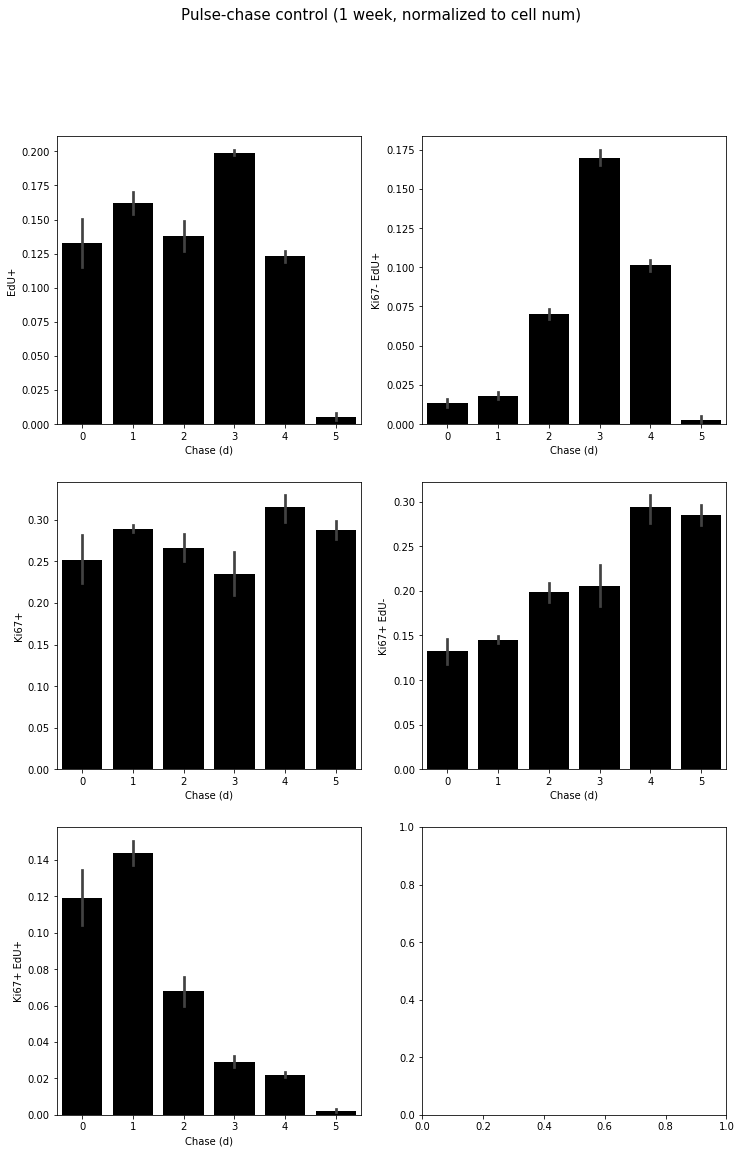

In [9]:
# Fig 2D: Pulse chase (Control t1, normalized to cell num)

# analysis info
run_type = 'merged'

# file and data paths
path_edu = data_path.format(run_type=run_type, fname=fname_lookup['edu'])
path_ki67 = data_path.format(run_type=run_type, fname=fname_lookup['cellstain'])
path_double = data_path.format(run_type=run_type, fname=fname_lookup['double'])

path_single_edu = data_path.format(run_type=run_type, fname=fname_lookup['single_edu'])
path_single_ki67 = data_path.format(run_type=run_type, fname=fname_lookup['single_ki67'])

path_cell = data_path.format(run_type=run_type, fname=fname_lookup['cell'])

# generate plotting data
datatray = pc_control_t1_datatray

df_edu = df_ratio_from_datatray(datatray, path_edu, path_cell)
df_ki67 = df_ratio_from_datatray(datatray, path_ki67, path_cell)
df_double = df_ratio_from_datatray(datatray, path_double, path_cell)

df_single_edu = df_ratio_from_datatray(datatray, path_single_edu, path_cell)
df_single_ki67 = df_ratio_from_datatray(datatray, path_single_ki67, path_cell)

# plot settings
title = 'Pulse-chase control (1 week, normalized to cell num)'
plot_type = 'bar'
plot_palette = 'black'

# plot
fig, axes = plt.subplots(3,2, figsize=(12, 18))

sns.factorplot(data=df_edu, x='name', y='val', kind=plot_type, size=6, color=plot_palette, ax=axes[0,0]);
axes[0,0].set_xlabel('Chase (d)')
axes[0,0].set_ylabel('EdU+')
plt.close()

sns.factorplot(data=df_ki67, x='name', y='val', kind=plot_type, size=6, color=plot_palette, ax=axes[1,0])
axes[1,0].set_xlabel('Chase (d)')
axes[1,0].set_ylabel('Ki67+')
plt.close()

sns.factorplot(data=df_double, x='name', y='val', kind=plot_type, size=6, color=plot_palette, ax=axes[2,0])
axes[2,0].set_xlabel('Chase (d)')
axes[2,0].set_ylabel('Ki67+ EdU+')
plt.close()

sns.factorplot(data=df_single_edu, x='name', y='val', kind=plot_type, size=6, color=plot_palette, ax=axes[0,1])
axes[0,1].set_xlabel('Chase (d)')
axes[0,1].set_ylabel('Ki67- EdU+')
plt.close()

sns.factorplot(data=df_single_ki67, x='name', y='val', kind=plot_type, size=6, color=plot_palette, ax=axes[1,1])
axes[1,1].set_xlabel('Chase (d)')
axes[1,1].set_ylabel('Ki67+ EdU-')
plt.close()

plt.suptitle(title, fontsize=15)

# save
if save_plot:
    save_csv_fig(subdir=subdir, fname='fig2d', ax=fig, df=df_single_ki67)

/Users/ichen/Documents/bin/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


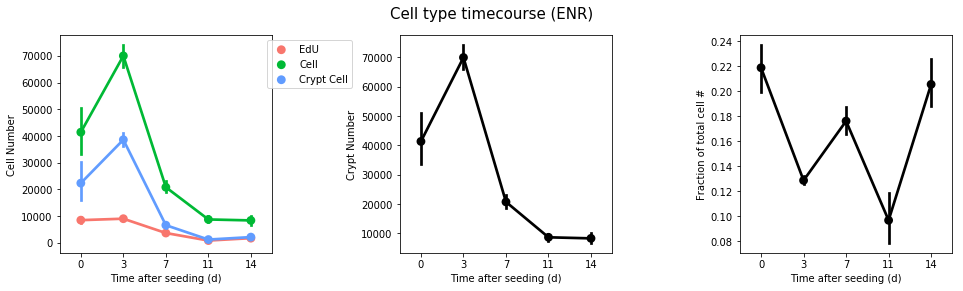

In [10]:
# Fig 2E: Cell type time course

# analysis info
run_type = 'merged'

# file and data paths
path_edu = data_path.format(run_type=run_type, fname=fname_lookup['edu'])
path_cell = data_path.format(run_type=run_type, fname=fname_lookup['cell'])
path_crypt = data_path.format(run_type=run_type, fname=fname_lookup['crypt'])

path_crypt_cell = data_path.format(run_type=run_type, fname=fname_lookup['crypt_cell'])

# generate plotting data
datatray = celltype_enr_datatray

df_edu = df_from_datatray(datatray, path_edu, label='EdU')
df_cell = df_from_datatray(datatray, path_cell, label='Cell')
df_crypt = df_from_datatray(datatray, path_crypt, label='Crypt')
df_crypt_cell = df_from_datatray(datatray, path_crypt_cell, label='Crypt Cell')

df_ratio_edu = df_ratio_from_datatray(datatray, path_edu, path_cell, label='% EdU')

df_num = df_edu.append(df_cell)
df_num = df_num.append(df_crypt_cell)

df_all = df_num.append(df_ratio_edu)

# plot settings
title = 'Cell type timecourse (ENR)'
plot_type = 'point'
plot_palette = line_palette_celltype

# plot
fig, axes = plt.subplots(1,3, figsize=(16, 4))
plt.subplots_adjust(wspace=0.6)

sns.factorplot(data=df_num, x='name', y='val', hue='label', order=['0', '3', '7', '11', '14'], kind=plot_type, size=6, palette=plot_palette, ax=axes[0]);
axes[0].set_xlabel('Time after seeding (d)')
axes[0].set_ylabel('Cell Number')
axes[0].legend(bbox_to_anchor=(1.4, 1))
plt.close()

sns.factorplot(data=df_cell, x='name', y='val', order=['0', '3', '7', '11', '14'], kind=plot_type, size=6, color='k', ax=axes[1])
axes[1].set_xlabel('Time after seeding (d)')
axes[1].set_ylabel('Crypt Number')
axes[1].legend(bbox_to_anchor=(1.3, 1))
plt.close()

sns.factorplot(data=df_ratio_edu, x='name', y='val', order=['0', '3', '7', '11', '14'], kind=plot_type, size=6, color='k', ax=axes[2])
axes[2].set_xlabel('Time after seeding (d)')
axes[2].set_ylabel('Fraction of total cell #')
axes[2].legend(bbox_to_anchor=(1.45, 1))
plt.close()

plt.suptitle(title, fontsize=15)

# save
if save_plot:
    save_csv_fig(subdir=subdir, fname='fig2e', ax=fig, df=df_all)

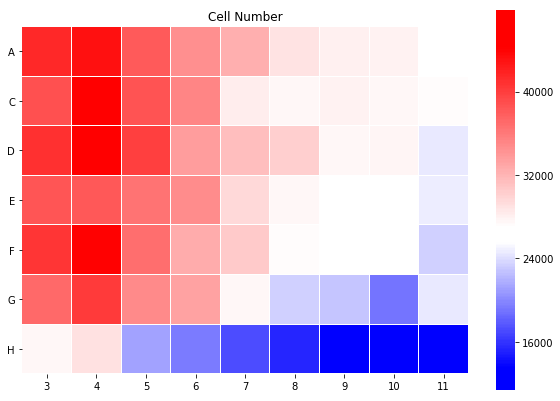

In [11]:
# Fig 3A: Cell number heatmap

# analysis info
run_type = 'merged'
exp1 = 'ct24_control1'
exp2 = 'ct24_control2'

# file and data paths
fname = fname_lookup['cell']
path_template = data_path.format(run_type=run_type, fname=fname)

# load csv files
mat1 = pd.read_csv(path_template.format(exp=exp1), header=None).as_matrix()
mat2 = pd.read_csv(path_template.format(exp=exp2), header=None).as_matrix()

# drop well 
mat2[7][8] = np.nan #H9

# crop matrix
mat1 = mat1[np.ix_(wntbmp_rows, wntbmp_cols)]
mat2 = mat2[np.ix_(wntbmp_rows, wntbmp_cols)]

# calculate average heatmap
avg_mat = np.nanmean(np.array([mat1, mat2]), axis=0)

# control center (A11)
center_x = 0 
center_y = -1

# calculate dual colorbar
control1 = mat1[center_x][center_y]
control2 = mat2[center_x][center_y]
max_val = max(np.amax(mat1), np.amax(mat2))
min_val = min(np.amin(mat1), np.amin(mat2))
levels = get_levels(control1, control2, max_val, min_val)
vmax = get_vmax(control1, control2, max_val, min_val)
heatmap_palette = red_blue_colormap(levels)

# plot settings
plot_title = 'Cell Number'
plot_type = 'bar'
plot_color = 'black'

# plot heatmap
mpl.rcParams['figure.figsize'] = fig_sz
fig = plt.gcf()
ax = sns.heatmap(avg_mat, linewidths=.01, cmap=heatmap_palette, yticklabels=[ylabs[i] for i in wntbmp_rows], 
    xticklabels=[xlabs[i] for i in wntbmp_cols], vmax=vmax, center=avg_mat[center_x][center_y], square=True)
ax.set_title(plot_title)
plt.yticks(rotation=0) 
plt.show()

# save 
if save_plot:
    save_csv_fig(subdir=subdir, fname='fig3a', fig=fig, mat=avg_mat)

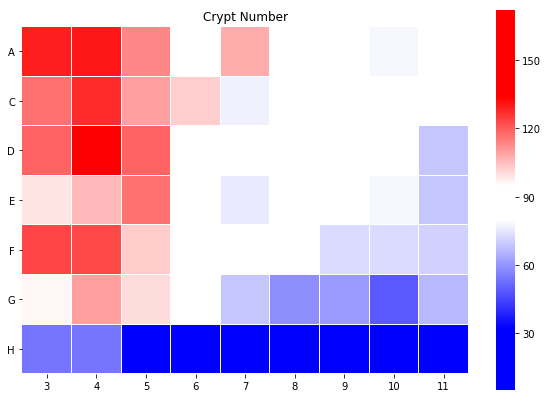

In [12]:
# Fig 3B: Crypt number heatmap

# analysis info
run_type = 'merged'
exp1 = 'ct24_control1'
exp2 = 'ct24_control2'

# file and data paths
fname = fname_lookup['crypt']
path_template = data_path.format(run_type=run_type, fname=fname)

# load csv files
mat1 = pd.read_csv(path_template.format(exp=exp1), header=None).as_matrix()
mat2 = pd.read_csv(path_template.format(exp=exp2), header=None).as_matrix()

# drop well 
mat2[7][8] = np.nan #H9

# crop matrix
mat1 = mat1[np.ix_(wntbmp_rows, wntbmp_cols)]
mat2 = mat2[np.ix_(wntbmp_rows, wntbmp_cols)]

# calculate average heatmap
avg_mat = np.nanmean(np.array([mat1, mat2]), axis=0)

# calculate dual colorbar
control1 = mat1[0][8] #A11 is control
control2 = mat2[0][8]
max_val = max(np.amax(mat1), np.amax(mat2))
min_val = min(np.amin(mat1), np.amin(mat2))
levels = get_levels(control1, control2, max_val, min_val)
vmax = get_vmax(control1, control2, max_val, min_val)
heatmap_palette = red_blue_colormap(levels)

# plot settings
plot_title = 'Crypt Number'
plot_type = 'bar'
plot_color = 'black'

# plot
mpl.rcParams['figure.figsize'] = fig_sz
fig = plt.gcf()
ax = sns.heatmap(avg_mat, linewidths=.01, cmap=heatmap_palette, yticklabels=[ylabs[i] for i in wntbmp_rows], 
    xticklabels=[xlabs[i] for i in wntbmp_cols], vmax = vmax, center=avg_mat[center_x][center_y], square=True)
ax.set_title(plot_title)
plt.yticks(rotation=0) 
plt.show()

# save 
if save_plot:
    save_csv_fig(subdir=subdir, fname='fig3b', fig=fig, mat=avg_mat)

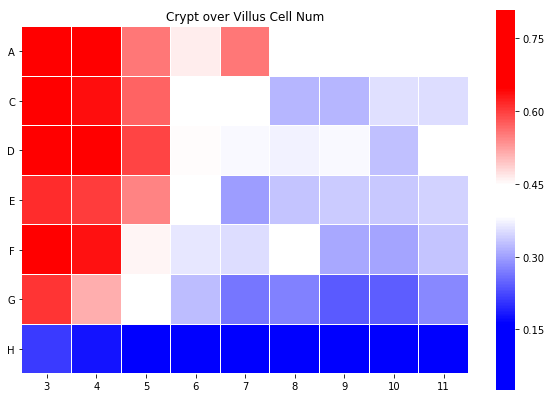

In [13]:
# Fig 3C: Crypt/villus ratio heatmap

# analysis info
run_type = 'merged'
exp1 = 'ct24_control1'
exp2 = 'ct24_control2'

# file and data paths
fname_top = fname_lookup['crypt_cell']
fname_bot = fname_lookup['villus_cell']

path_top = data_path.format(run_type=run_type, fname=fname_top)
path_bot = data_path.format(run_type=run_type, fname=fname_bot)

# load csv files
mat1_top = pd.read_csv(path_top.format(exp=exp1), header=None).as_matrix()
mat1_bot = pd.read_csv(path_bot.format(exp=exp1), header=None).as_matrix()

mat2_top = pd.read_csv(path_top.format(exp=exp2), header=None).as_matrix()
mat2_bot = pd.read_csv(path_bot.format(exp=exp2), header=None).as_matrix()

# drop well 
mat2_top[7][8] = np.nan #H9
mat2_bot[7][8] = np.nan #H9

# crop matrix
mat1_top = mat1_top[np.ix_(wntbmp_rows, wntbmp_cols)]
mat1_bot = mat1_bot[np.ix_(wntbmp_rows, wntbmp_cols)]
mat2_top = mat2_top[np.ix_(wntbmp_rows, wntbmp_cols)]
mat2_bot = mat2_bot[np.ix_(wntbmp_rows, wntbmp_cols)]

# calculate ratio heatmap
mat1 = mat1_top/mat1_bot
mat2 = mat2_top/mat2_bot
ratio_mat = np.nanmean(np.array([mat1, mat2]), axis=0)

# calculate dual colorbar
control1 = mat1[0][8] #A11 is control
control2 = mat2[0][8]
max_val = max(np.amax(mat1), np.amax(mat2))
min_val = min(np.amin(mat1), np.amin(mat2))
levels = get_levels(control1, control2, max_val, min_val)
vmax = get_vmax(control1, control2, max_val, min_val)
heatmap_palette = red_blue_colormap(levels)

# plot settings
plot_title = 'Crypt over Villus Cell Num'
plot_type = 'bar'
plot_color = 'black'

# plot
mpl.rcParams['figure.figsize'] = fig_sz
fig = plt.gcf()
ax = sns.heatmap(ratio_mat, linewidths=.01, cmap=heatmap_palette, yticklabels=[ylabs[i] for i in wntbmp_rows], 
    xticklabels=[xlabs[i] for i in wntbmp_cols], vmax=vmax, center=ratio_mat[center_x][center_y], square=True)
ax.set_title(plot_title)
plt.yticks(rotation=0) 
plt.show()

# save 
if save_plot:
    save_csv_fig(subdir=subdir, fname='fig3c', fig=fig, mat=avg_mat)

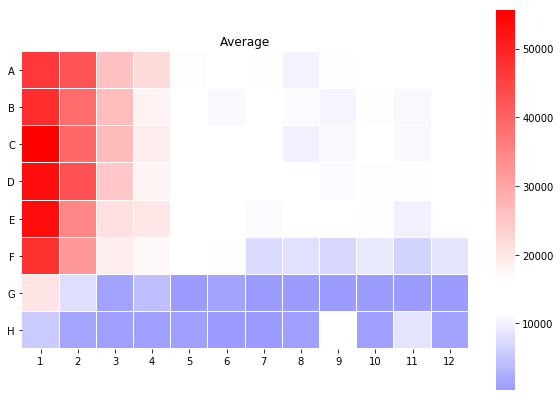

In [14]:
# Fig 3D: Cell number heatmap (2 color bar)

# analysis info
run_type = 'merged'
exps = ['ct_wntbmp_p1', 'ct_wntbmp_p2', 'ct_wntbmp_p3']

# file and data paths
fname = fname_lookup['cell']
path_template = data_path.format(run_type=run_type, fname=fname)

# control center (A12, A11)
centers = [[0,-1], [0,-2]] 

fold = 4

# load csv files
mats = []
for exp in exps:
    mat = pd.read_csv(path_template.format(exp=exp), header=None).as_matrix()
    mats.append(mat)
    
mats[0][7][4] = np.nan
mats[0][7][5] = np.nan
mats[0][6][8] = np.nan
mats[0][7][8] = np.nan
mats[1][7][7] = np.nan

# calculate average heatmap
avg_mat = np.nanmean(np.array(mats), axis=0)

# calculate dual colorbar
control_vals = [mat[c[0]][c[1]] for mat in mats for c in centers]
control1 = np.nanmin(control_vals)
control2 = np.nanmax(control_vals)
max_val = np.nanmax(mats)
min_val = np.nanmin(mats)
levels = get_levels(control1, control2, max_val, min_val, fold=fold)
vmax = get_vmax_fold(control1, control2, fold)
plot_center = get_center(control1, control2)
heatmap_palette = red_blue_colormap(levels)

mats.append(avg_mat)

# plot settings
plot_title = 'Cell Number'
plot_type = 'bar'
plot_color = 'black'
subplot_titles = ['P1', 'P2', 'P3', 'Average']

# plot heatmap
fig, ax = plt.subplots(1,1)
i=3
sns.heatmap(mats[i], linewidths=.01, cmap=heatmap_palette, yticklabels=ylabs, 
xticklabels=xlabs, vmax=vmax, center=plot_center, square=True, ax=ax)
ax.set_title(subplot_titles[i])
plt.setp(ax.get_yticklabels(), rotation=0)

plt.show()

# save 
if save_plot:
    save_csv_fig(subdir=subdir, fname='fig3d', fig=fig, mat=avg_mat)

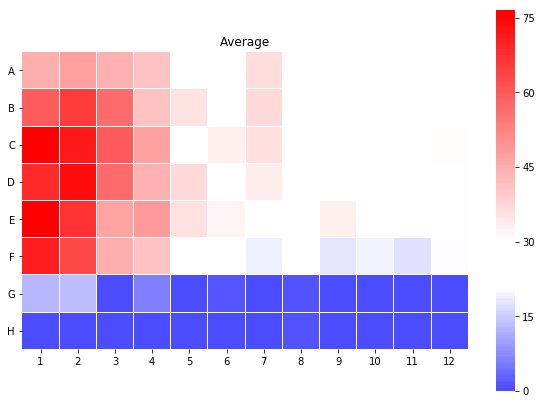

In [15]:
# Fig 3E: Crypt heatmap (2 color bar)

# analysis info
run_type = 'merged'
exps = ['ct_wntbmp_p1', 'ct_wntbmp_p2', 'ct_wntbmp_p3']

# file and data paths
fname = fname_lookup['crypt']
path_template = data_path.format(run_type=run_type, fname=fname)

# control center (A12, A11)
centers = [[0,-1], [0,-2]] 

fold = 3

# load csv files
mats = []
for exp in exps:
    mat = pd.read_csv(path_template.format(exp=exp), header=None).as_matrix()
    mats.append(mat)
    
mats[0][7][4] = np.nan
mats[0][7][5] = np.nan
mats[0][6][8] = np.nan
mats[0][7][8] = np.nan
mats[1][7][7] = np.nan

# calculate average heatmap
avg_mat = np.nanmean(np.array(mats), axis=0)

# calculate dual colorbar
control_vals = [mat[c[0]][c[1]] for mat in mats for c in centers]
control1 = np.nanmin(control_vals)
control2 = np.nanmax(control_vals)
max_val = np.nanmax(mats)
min_val = np.nanmin(mats)
levels = get_levels(control1, control2, max_val, min_val, fold=fold)
vmax = get_vmax_fold(control1, control2, fold)
plot_center = get_center(control1, control2)
heatmap_palette = red_blue_colormap(levels)

mats.append(avg_mat)

# plot settings
plot_title = 'Crypt Number'
plot_type = 'bar'
plot_color = 'black'
subplot_titles = ['P1', 'P2', 'P3', 'Average']

# plot heatmap
fig, ax = plt.subplots(1,1)
i=3
sns.heatmap(mats[i], linewidths=.01, cmap=heatmap_palette, yticklabels=ylabs, 
xticklabels=xlabs, vmax=vmax, center=plot_center, square=True, ax=ax)
ax.set_title(subplot_titles[i])
plt.setp(ax.get_yticklabels(), rotation=0)

plt.show()

# save 
if save_plot:
    save_csv_fig(subdir=subdir, fname='fig3e', fig=fig, mat=avg_mat)

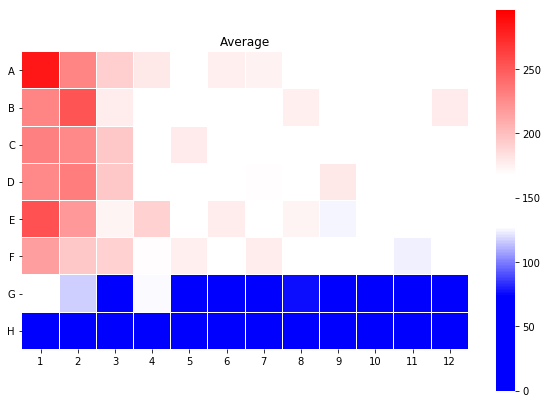

In [16]:
# Fig 3F: Average cells per crypt heatmap (2 color bar)

# analysis info
run_type = 'merged'
exps = ['ct_wntbmp_p1', 'ct_wntbmp_p2', 'ct_wntbmp_p3']

# file and data paths
fname_top = fname_lookup['crypt_cell']
fname_bot = fname_lookup['crypt']
path_template_top = data_path.format(run_type=run_type, fname=fname_top)
path_template_bot = data_path.format(run_type=run_type, fname=fname_bot)

# control center (A12, A11)
centers = [[0,-1], [0,-2]] 

fold = 2

# load csv files
mats = []
for exp in exps:
    mat_top = pd.read_csv(path_template_top.format(exp=exp), header=None).as_matrix()
    mat_bot = pd.read_csv(path_template_bot.format(exp=exp), header=None).as_matrix()
    mat = mat_top/mat_bot
    mats.append(np.nan_to_num(mat))
    
mats[0][7][4] = np.nan
mats[0][7][5] = np.nan
mats[0][6][8] = np.nan
mats[0][7][8] = np.nan
mats[1][7][7] = np.nan

# calculate average heatmap
avg_mat = np.nanmean(np.array(mats), axis=0)

# calculate dual colorbar
control_vals = [mat[c[0]][c[1]] for mat in mats for c in centers]
control1 = np.nanmin(control_vals)
control2 = np.nanmax(control_vals)
max_val = np.nanmax(mats)
min_val = np.nanmin(mats)
levels = get_levels(control1, control2, max_val, min_val, fold=fold)
vmax = get_vmax_fold(control1, control2, fold)
plot_center = get_center(control1, control2)
heatmap_palette = red_blue_colormap(levels)

mats.append(avg_mat)

# plot settings
plot_title = 'Average cells per crypt'
plot_type = 'bar'
plot_color = 'black'
subplot_titles = ['P1', 'P2', 'P3', 'Average']

# plot heatmap
fig, ax = plt.subplots(1,1)
i=3
sns.heatmap(mats[i], linewidths=.01, cmap=heatmap_palette, yticklabels=ylabs, 
xticklabels=xlabs, vmax=vmax, center=plot_center, square=True, ax=ax)
ax.set_title(subplot_titles[i])
plt.setp(ax.get_yticklabels(), rotation=0)

plt.show()

# save 
if save_plot:
    save_csv_fig(subdir=subdir, fname='fig3f', fig=fig, mat=avg_mat)

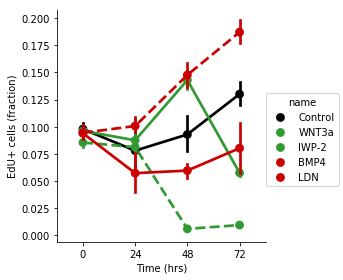

In [17]:
# Fig 4B: EdU+ cells (fraction) time course

# analysis info
run_type = 'merged'

# file and data paths
fname_top = fname_lookup['edu']
fname_bot = fname_lookup['cell']

path_top = data_path.format(run_type=run_type, fname=fname_top)
path_bot = data_path.format(run_type=run_type, fname=fname_bot)

# generate plotting data
datatray = fig4_line_datatray

df = df_ratio_from_matrix(datatray, path_top, path_bot)

# plot settings
x_title = 'Time (hrs)'
y_title = 'EdU+ cells (fraction)'
plot_type = 'point'
plot_palette = line_palette
plot_style = line_style

# plot
ax = sns.factorplot(data=df, x='time', y='val', hue='name', kind=plot_type, palette=plot_palette, linestyles=plot_style)
ax.set_axis_labels(x_title, y_title)

# save
if save_plot:
    save_csv_fig(subdir=subdir, fname='fig4b', ax=ax, df=df)

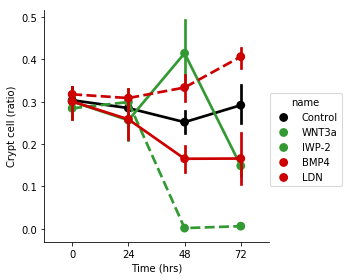

In [18]:
# Fig 4C: Crypt/villus ratio time course

# analysis info
run_type = 'merged'

# file and data paths
fname_top = fname_lookup['crypt_cell']
fname_bot = fname_lookup['cell']

path_top = data_path.format(run_type=run_type, fname=fname_top)
path_bot = data_path.format(run_type=run_type, fname=fname_bot)

# generate plotting data
datatray = fig4_line_datatray

df = df_ratio_from_matrix(datatray, path_top, path_bot)

# plot settings
x_title = 'Time (hrs)'
y_title = 'Crypt cell (ratio)'
plot_type = 'point'
plot_palette = line_palette
plot_style = line_style

# plot
ax = sns.factorplot(data=df, x='time', y='val', hue='name', kind=plot_type, palette=plot_palette, linestyles=plot_style)
ax.set_axis_labels(x_title, y_title)

# save
if save_plot:
    save_csv_fig(subdir=subdir, fname='fig4c', ax=ax, df=df)

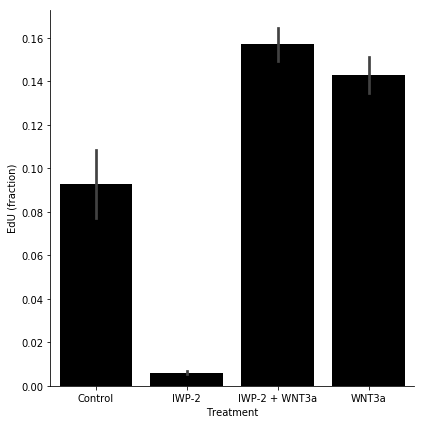

In [19]:
# Fig 4D: EdU+ fraction 48h

# analysis info
run_type = 'merged'

# file and data paths
fname_top = fname_lookup['edu']
fname_bot = fname_lookup['cell']

path_top = data_path.format(run_type=run_type, fname=fname_top)
path_bot = data_path.format(run_type=run_type, fname=fname_bot)

# generate plotting data
datatray = fig4_bar_48h_datatray

df = df_ratio_from_matrix(datatray, path_top, path_bot)

# plot settings
x_title = 'Treatment'
y_title = 'EdU (fraction)'
plot_type = 'bar'
plot_palette = 'black'

# plot
ax = sns.factorplot(data=df, x='name', y='val', kind=plot_type, size=6, color=plot_palette)
ax.set_axis_labels(x_title, y_title)

# save
if save_plot:
    save_csv_fig(subdir=subdir, fname='fig4d', ax=ax, df=df)

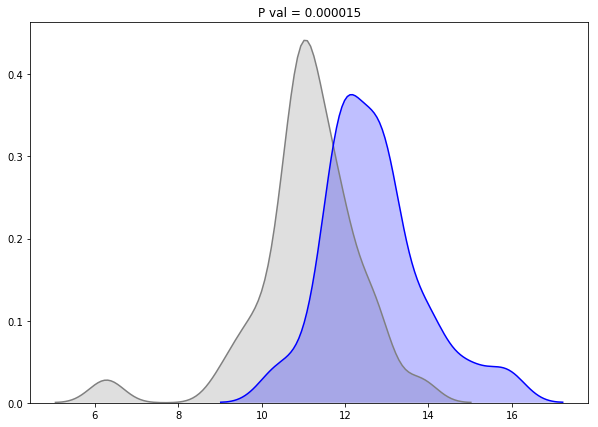

In [20]:
# Fig 4F: Dispersion of crypt

# setup paths
path_prefix = os.path.join(path_init['processed_path'], 'ct25_72/merged/combined/well_measure/')
csv_file = 'edu_dispersion_well_measure.csv'
csv_path = os.path.join(path_prefix, csv_file)
df = pd.read_csv(csv_path, index_col=False)

# distribution of distances in crypts within the same well is relatively similar
wells = ['C05','D05']

treat = []

for curr_well in wells:
    crypt_num_lst = set(df.loc[df['well'] == curr_well]['crypt_num'])
    treat += [np.nanmean(df.loc[(df['crypt_num'] == i) & (df['well'] == curr_well)]['d_nn']) for i in crypt_num_lst]

wells = ['A01', 'B01', 'B02']

control = []

for curr_well in wells:
    crypt_num_lst = set(df.loc[df['well'] == curr_well]['crypt_num'])
    control += [np.nanmean(df.loc[(df['crypt_num'] == i) & (df['well'] == curr_well)]['d_nn']) for i in crypt_num_lst]

# distance conversion
treat = np.array(treat) * 0.65
control = np.array(control) * 0.65

fig, ax = plt.subplots(1,1)

sns.kdeplot(data=control, shade=True, color='grey', ax=ax)
sns.kdeplot(data=treat, shade=True, color='blue', ax=ax)

tstat = stats.ttest_ind(control, treat)
plt.title('P val = {:3f}'.format(tstat.pvalue))

df_plotted = pd.DataFrame()
df_plotted['control'] = control
df_plotted['treatment'] = pd.Series(treat)

# save
if save_plot:
    save_csv_fig(subdir=subdir, fname='fig4f', ax=fig, df=df_plotted)

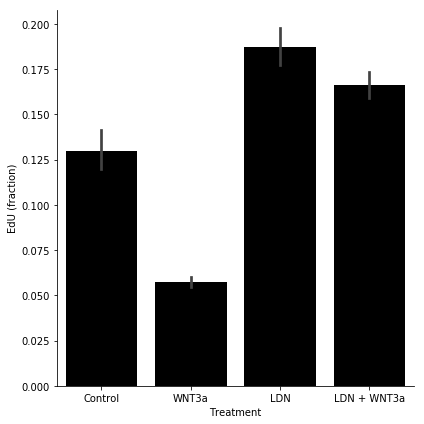

In [21]:
# Fig 4G: EdU+ fraction 72h

# analysis info
run_type = 'merged'

# file and data paths
fname_top = fname_lookup['edu']
fname_bot = fname_lookup['cell']

path_top = data_path.format(run_type=run_type, fname=fname_top)
path_bot = data_path.format(run_type=run_type, fname=fname_bot)

# generate plotting data
datatray = fig4_bar_72h_datatray

df = df_ratio_from_matrix(datatray, path_top, path_bot)

# plot settings
x_title = 'Treatment'
y_title = 'EdU (fraction)'
plot_type = 'bar'
plot_palette = 'black'

# plot
ax = sns.factorplot(data=df, x='name', y='val', kind=plot_type, size=6, color=plot_palette)
ax.set_axis_labels(x_title, y_title)

# save
if save_plot:
    save_csv_fig(subdir=subdir, fname='fig4g', ax=ax, df=df)

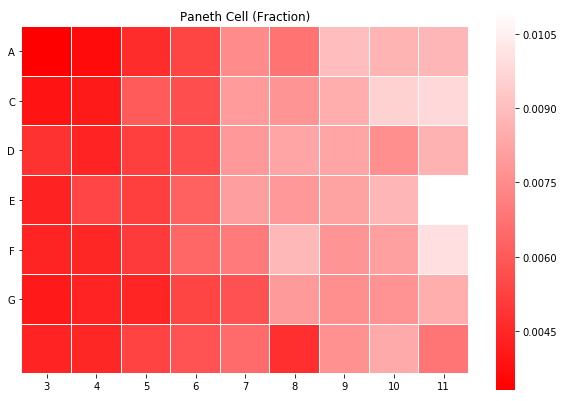

In [22]:
# Fig 4H: Paneth cell (fraction) wnt/bmp matrix

# analysis info
run_type_top = 'paneth'
run_type_bot = 'merged'
exp1 = 'ct24_control1'
exp2 = 'ct24_control2'

# file and data paths
fname_top = fname_lookup['paneth_drop']
fname_bot = fname_lookup['cell']

path_top = data_path.format(run_type=run_type_top, fname=fname_top)
path_bot = data_path.format(run_type=run_type_bot, fname=fname_bot)

# load csv files
mat1_top = pd.read_csv(path_top.format(exp=exp1), header=None).as_matrix()
mat1_bot = pd.read_csv(path_bot.format(exp=exp1), header=None).as_matrix()

mat2_top = pd.read_csv(path_top.format(exp=exp2), header=None).as_matrix()
mat2_bot = pd.read_csv(path_bot.format(exp=exp2), header=None).as_matrix()

# crop matrix
mat1_top = mat1_top[np.ix_(wntbmp_rows, wntbmp_cols)]
mat1_bot = mat1_bot[np.ix_(wntbmp_rows, wntbmp_cols)]
mat2_top = mat2_top[np.ix_(wntbmp_rows, wntbmp_cols)]
mat2_bot = mat2_bot[np.ix_(wntbmp_rows, wntbmp_cols)]

# calculate ratio heatmap
mat1 = mat1_top/mat1_bot
mat2 = mat2_top/mat2_bot
ratio_mat = np.nanmean(np.array([mat1, mat2]), axis=0)

# heatmap colorbar
levels = [0,1]
heatmap_palette = red_colormap(levels)

# plot settings
plot_title = 'Paneth Cell (Fraction)'

# plot
mpl.rcParams['figure.figsize'] = fig_sz
fig = plt.gcf()
ax = sns.heatmap(ratio_mat, linewidths=.01, yticklabels=[ylabs[i] for i in paneth_rows], 
    xticklabels=[xlabs[i] for i in paneth_cols], cmap=heatmap_palette, square=True)
ax.set_title(plot_title)
plt.yticks(rotation=0) 
plt.show()

# save 
if save_plot:
    save_csv_fig(subdir=subdir, fname='fig4h', fig=fig, mat=ratio_mat)

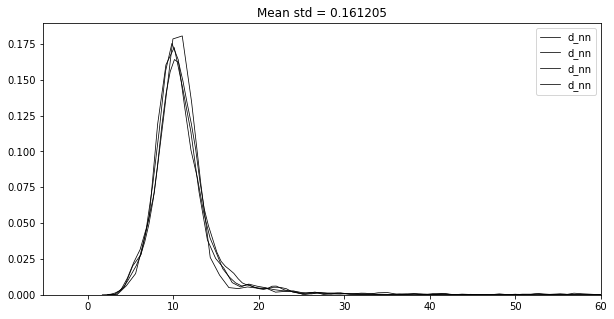

In [23]:
# Supp Fig 4F: Dispersion robustness

# setup paths
path_prefix = os.path.join(path_init['processed_path'], 'ct25_72/merged/combined/well_measure/')
csv_file = 'edu_dispersion_well_measure.csv'
csv_path = os.path.join(path_prefix, csv_file)
df = pd.read_csv(csv_path, index_col=False)

wells = ['A01', 'A02', 'B01', 'B02']

fig, axes = plt.subplots(1,1, figsize=(10,5))

control_means = []
df_plotted = pd.DataFrame()

for curr_well in wells:
    crypt_num_lst = set(df.loc[df['well'] == curr_well]['crypt_num'])
    distances = df.loc[(df['well'] == curr_well)]['d_nn']*0.65
    sns.kdeplot(distances, color='black', lw=0.75, ax=axes)
    control_means.append(np.mean(distances))
    df_plotted[curr_well] = pd.Series(distances)
    
axes.set_xlim(right=60)

plt.title('Mean std = {:3f}'.format(np.std(control_means)))

if save_plot:
    save_csv_fig(subdir=subdir, fname='suppfig4f', fig=fig, df=df_plotted)